In [33]:
import numpy as np 
import pandas as pd 
import datetime as dt 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [34]:
df = pd.read_csv("online_retail.csv")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [36]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [38]:
df = df.dropna(subset=['CustomerID'])

In [39]:
df.isnull().sum().sum()

np.int64(0)

### check and clean the data 

In [40]:
df.duplicated().sum()

np.int64(5225)

In [41]:
df = df.drop_duplicates()
df.duplicated().sum()

np.int64(0)

In [42]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,401604.000000,401604.000000,401604.000000
mean,12.183273,3.474064,15281.160818
std,250.283037,69.764035,1714.006089
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13939.000000
50%,5.000000,1.950000,15145.000000
75%,12.000000,3.750000,16784.000000
max,80995.000000,38970.000000,18287.000000


In [43]:
df = df[(df['Quantity']>0) & (df['UnitPrice']>0)]
df.describe()

,Quantity,UnitPrice,CustomerID
count,392692.000000,392692.000000,392692.000000
mean,13.119702,3.125914,15287.843865
std,180.492832,22.241836,1713.539549
min,1.000000,0.001000,12346.000000
25%,2.000000,1.250000,13955.000000
50%,6.000000,1.950000,15150.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,8142.750000,18287.000000


In [44]:
df.shape

(392692, 8)

In [46]:
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])
def get_month(x) : return dt.datetime(x.year, x.month, 1)
df['InvoiceMonth'] = df['InvoiceDate'].apply(get_month)
grouping = df.groupby('CustomerID')['InvoiceMonth']
df['CohortMonth'] = grouping.transform('min')
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,2011-12-01,2011-08-01
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,2011-12-01,2011-08-01
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12-01,2011-08-01
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12-01,2011-08-01
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France,2011-12-01,2011-08-01


In [47]:
def get_month_int (dframe, column):
    year = dframe[column].dt.year 
    month = dframe[column].dt.month 
    day = dframe[column].dt.day 
    return year, month, day 

invoice_year, invoice_month,_ = get_month_int(df, 'InvoiceMonth') 
cohort_year, cohort_month,_ = get_month_int(df, 'CohortMonth')

year_diff = invoice_year - cohort_year
month_diff = invoice_month - cohort_month

df['CohortIndex'] = year_diff * 12 + month_diff + 1

In [48]:
#Count monthly active customers from each cohort 
grouping = df.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique)
#Return number of unique elements in the object
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')
cohort_counts

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,885.0,324.0,286.0,340.0,321.0,352.0,321.0,309.0,313.0,350.0,331.0,445.0,235.0
2011-01-01,417.0,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0,49.0,NaN
2011-02-01,380.0,71.0,71.0,108.0,103.0,94.0,96.0,106.0,94.0,116.0,26.0,NaN,NaN
2011-03-01,452.0,68.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0,39.0,NaN,NaN,NaN
2011-04-01,300.0,64.0,61.0,63.0,59.0,68.0,65.0,78.0,22.0,NaN,NaN,NaN,NaN
2011-05-01,284.0,54.0,49.0,49.0,59.0,66.0,75.0,27.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,242.0,42.0,38.0,64.0,56.0,81.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,188.0,34.0,39.0,42.0,51.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,169.0,35.0,42.0,41.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Retention Rate Table

In [49]:
cohort_size = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_size, axis=0)
retention.round(3) * 100

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0,36.6,32.3,38.4,36.3,39.8,36.3,34.9,35.4,39.5,37.4,50.3,26.6
2011-01-01,100.0,22.1,26.6,23.0,32.1,28.8,24.7,24.2,30.0,32.6,36.5,11.8,NaN
2011-02-01,100.0,18.7,18.7,28.4,27.1,24.7,25.3,27.9,24.7,30.5,6.8,NaN,NaN
2011-03-01,100.0,15.0,25.2,19.9,22.3,16.8,26.8,23.0,27.9,8.6,NaN,NaN,NaN
2011-04-01,100.0,21.3,20.3,21.0,19.7,22.7,21.7,26.0,7.3,NaN,NaN,NaN,NaN
2011-05-01,100.0,19.0,17.3,17.3,20.8,23.2,26.4,9.5,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,17.4,15.7,26.4,23.1,33.5,9.5,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,18.1,20.7,22.3,27.1,11.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,20.7,24.9,24.3,12.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


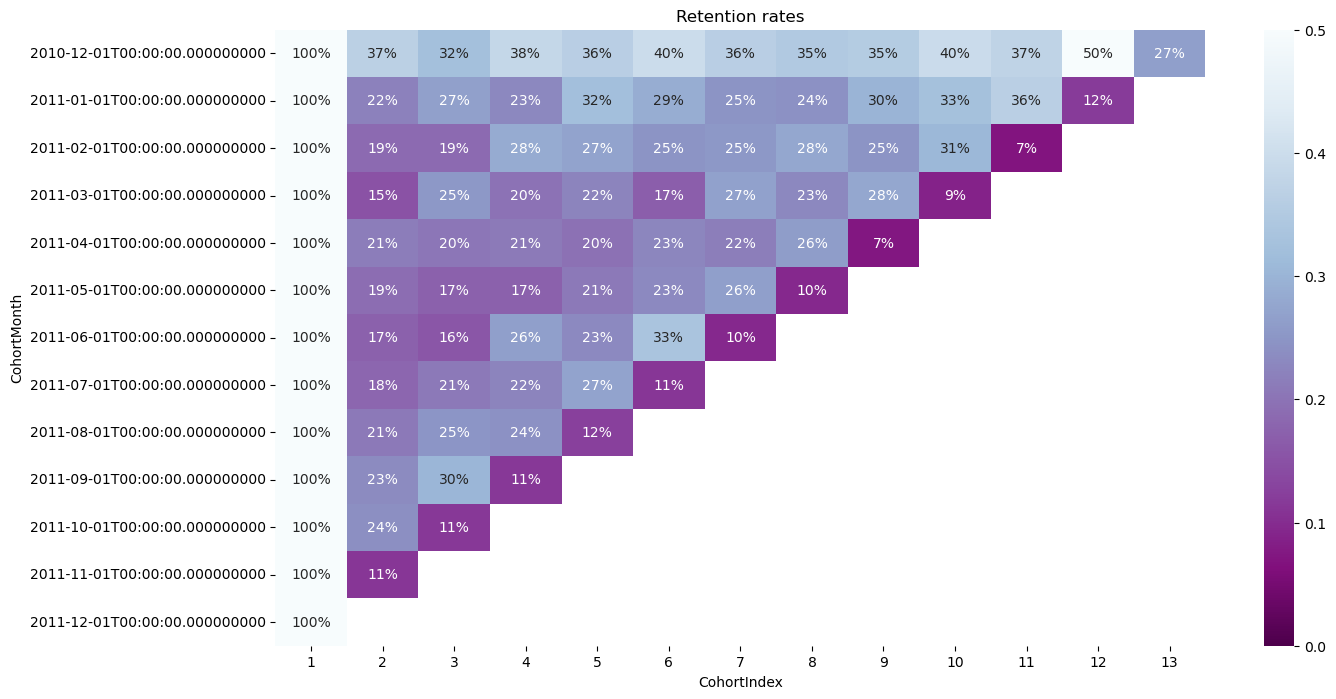

In [50]:
#Build the heatmap
plt.figure(figsize=(15, 8))
plt.title('Retention rates') 
sns.heatmap(data=retention, annot=True, fmt = '.0%', vmin=0.0, vmax=0.5, cmap='BuPu_r')
plt.show()

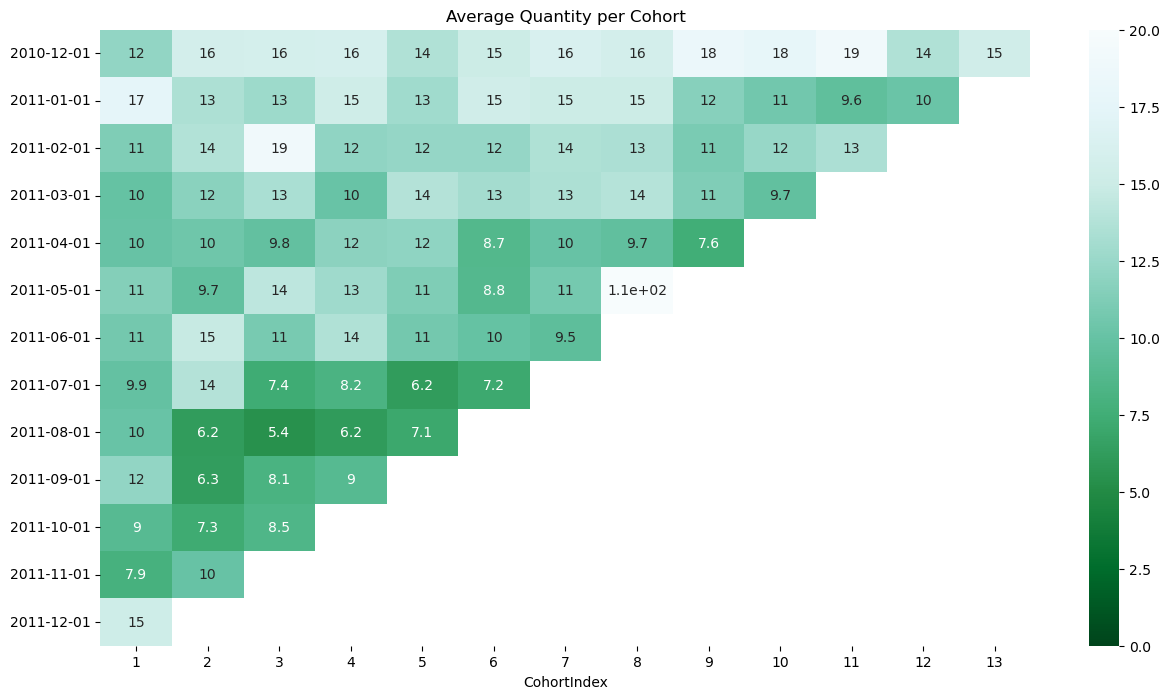

In [51]:
#Average quantity for each cohort
grouping = df.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['Quantity'].mean()
cohort_data = cohort_data.reset_index()
average_quantity = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='Quantity')
average_quantity.round(1)
average_quantity.index = average_quantity.index.date 

#Build the heatmap
plt.figure(figsize=(15, 8))
plt.title('Average Quantity per Cohort')
sns.heatmap(data=average_quantity, annot=True, vmin=0.0, vmax=20, cmap='BuGn_r')
plt.show()

In [52]:
df['TotalSum'] = df['UnitPrice']* df['Quantity']

#Data Preparation Steps
print('Min Invoice Date:', df.InvoiceDate.dt.date.min(), 'max Invoice Date:', 
      df.InvoiceDate.dt.date.max())

df.head(3)

Min Invoice Date: 2010-12-01 max Invoice Date: 2011-12-09


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex,TotalSum
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01,1,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01,1,22.00


In [53]:
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)
snapshot_date

Timestamp('2011-12-10 12:50:00')

In [54]:
#calculate RFM metrics
rfm = df.groupby(['CustomerID']).agg({'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
                                       'InvoiceNo': 'count','TotalSum': 'sum' })

rfm.rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalSum': 'MonetaryValue'},
           inplace=True)

rfm.head()
                 

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40


In [55]:
#Building RFM segments
r_labels = range(4,0,-1)
f_labels = range(1,5)
m_labels = range(1,5)
r_quartiles = pd.qcut(rfm['Recency'], q=4, labels = r_labels)
f_quartiles = pd.qcut(rfm['Frequency'], q=4, labels = f_labels)
m_quartiles = pd.qcut(rfm['MonetaryValue'], q=4, labels = m_labels)
rfm = rfm.assign(R = r_quartiles.values, F = f_quartiles, M = m_quartiles)

#Build RFM Segment and RFM Score
def add_rfm(x) : return str(x['R']) + str(x['F']) + str(x['M'])
rfm['RFM_Segment'] = rfm.apply(add_rfm, axis=1)
rfm['RFM_Score'] = rfm[['R', 'F', 'M']].sum(axis=1)

rfm.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12346.0,326,1,77183.60,1,1,4,1.01.04.0,6
12347.0,2,182,4310.00,4,4,4,4.04.04.0,12
12348.0,75,31,1797.24,2,2,4,2.02.04.0,8
12349.0,19,73,1757.55,3,3,4,3.03.04.0,10
12350.0,310,17,334.40,1,1,2,1.01.02.0,4


## Analyzing RFM Segments

In [57]:
rfm.groupby(['RFM_Segment']).size().sort_values(ascending=False)[:5]

RFM_Segment
4.04.04.0    450
1.01.01.0    381
3.04.04.0    217
1.02.02.0    206
2.01.01.0    179
dtype: int64

In [58]:
rfm.groupby('RFM_Score').agg({'Recency':'mean', 'Frequency':'mean', 
                              'MonetaryValue':['mean', 'count']}).round(1)

Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Score                                      
3           260.7       8.2         157.4   381
4           177.2      13.6         240.0   388
5           152.9      21.2         366.6   518
6            95.9      27.9         820.8   457
7            79.6      38.0         758.1   463
8            64.1      56.0         987.3   454
9            45.9      78.7        1795.1   414
10           32.4     110.5        2056.4   426
11           21.3     186.9        4062.0   387
12            7.2     367.8        9285.9   450

### Use RFM score to group customer into Gold, silver and Bronze segments

In [59]:
def segment(df):
    if df['RFM_Score'] >= 9:
        return 'Gold'
    elif ((df['RFM_Score'] >= 5) & (df['RFM_Score'] < 9)):
        return 'Silver'
    else:
        return 'Bronze'


rfm['General_Segment'] = rfm.apply(segment, axis=1)

rfm.groupby('General_Segment').agg({'Recency':'mean', 'Frequency':'mean',
                                'MonetaryValue':['mean', 'count']}).round(1)

Recency Frequency MonetaryValue      
                   mean      mean          mean count
General_Segment                                      
Bronze            218.6      10.9         199.1   769
Gold               26.4     189.4        4394.7  1677
Silver             99.9      35.3         721.1  1892

## Data Pre-Processing for KMeans Clustering

In [60]:
rfm_rfm = rfm[['Recency', 'Frequency', 'MonetaryValue']]
print(rfm_rfm.describe())

           Recency    Frequency  MonetaryValue
count  4338.000000  4338.000000    4338.000000
mean     92.536422    90.523744    2048.688081
std     100.014169   225.506968    8985.230220
min       1.000000     1.000000       3.750000
25%      18.000000    17.000000     306.482500
50%      51.000000    41.000000     668.570000
75%     142.000000    98.000000    1660.597500
max     374.000000  7676.000000  280206.020000


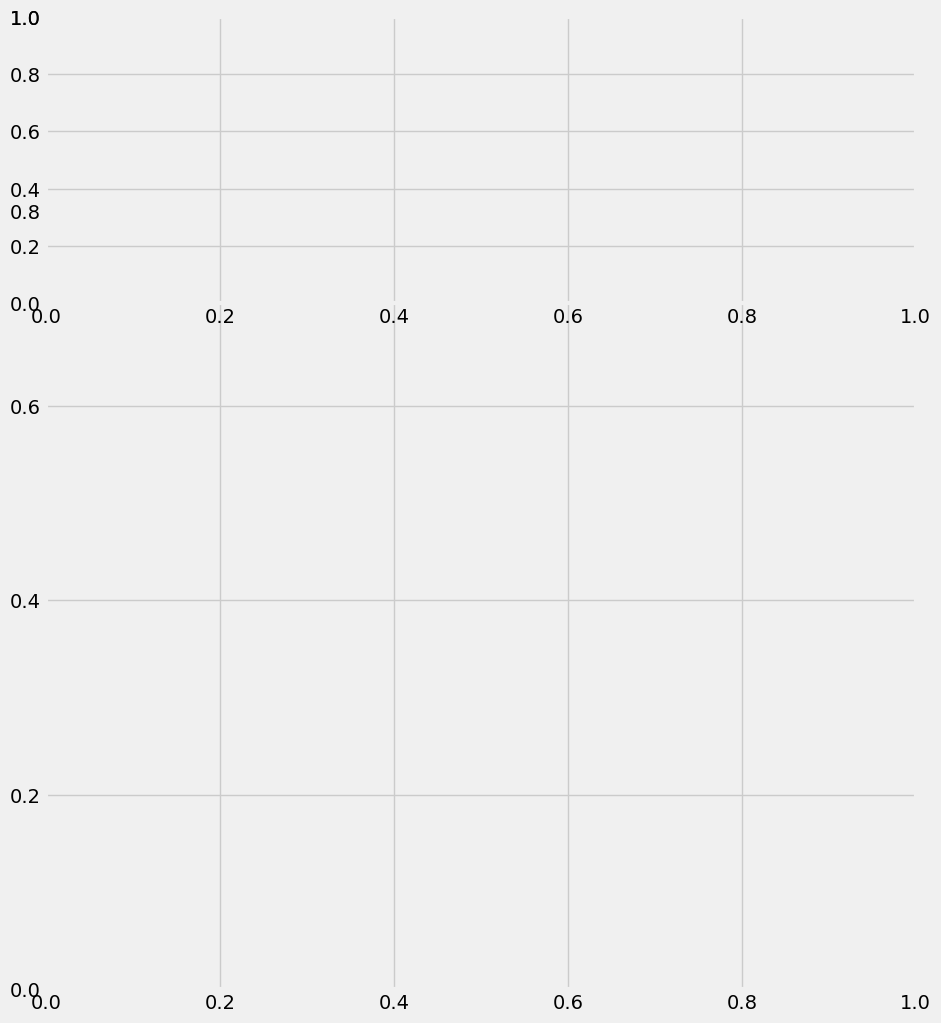

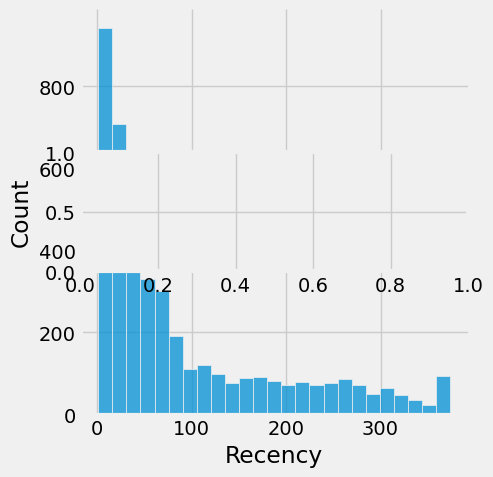

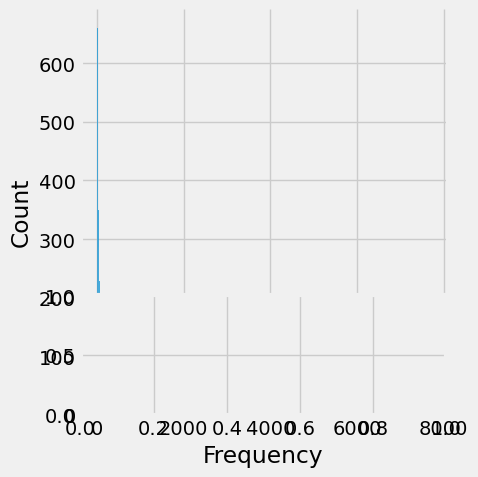

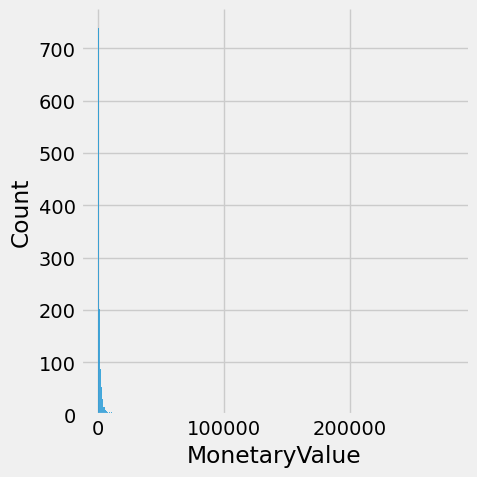

In [62]:
#plot the distribution of RFM values
f,ax = plt.subplots(figsize=(10, 12))
plt.subplot(3, 1, 1); sns.displot(rfm.Recency, label='Recency')
plt.subplot(3, 1, 2); sns.displot(rfm.Frequency, label='Frequency')
plt.subplot(3, 1, 3); sns.displot(rfm.MonetaryValue, label='MonetaryValue')
plt.style.use('fivethirtyeight')
plt.tight_layout()
plt.show()

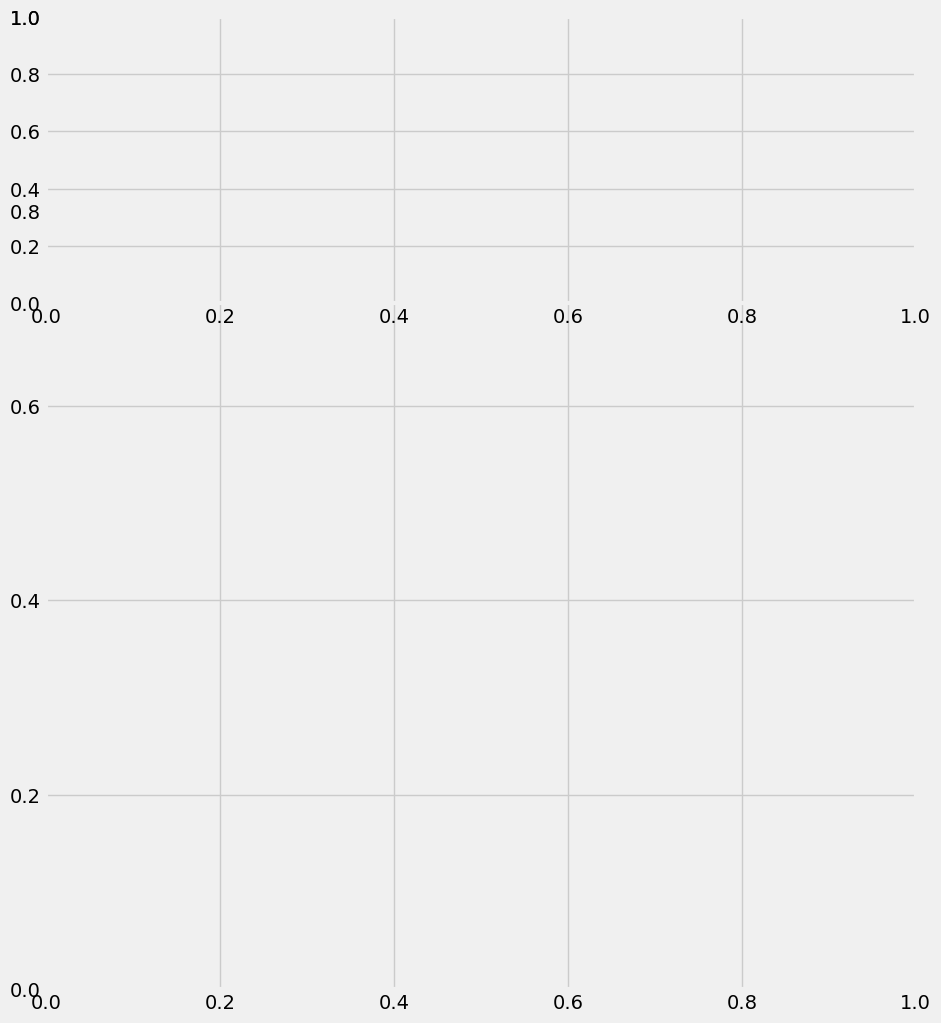

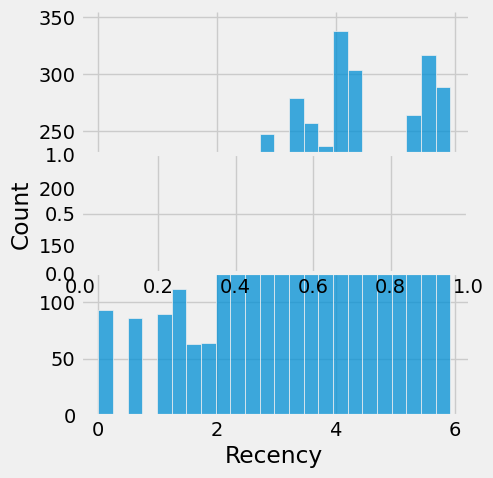

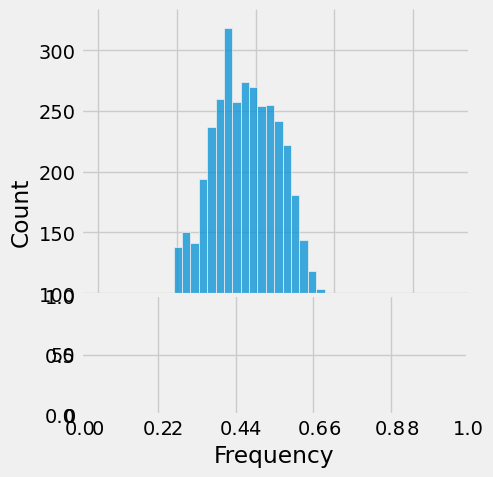

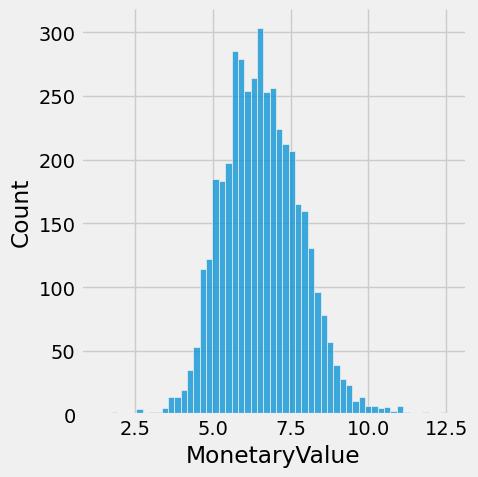

In [63]:
#Unskew the data with log transformation    
rfm_log = rfm_rfm[['Recency', 'Frequency', 'MonetaryValue']].apply(np.log, axis=1).round(3)
#or rfm_log = np.log(rfm_rfm)


#plot the distribution of RFM values
f,ax = plt.subplots(figsize=(10, 12))
plt.subplot(3, 1, 1); sns.displot(rfm_log.Recency, label='Recency')
plt.subplot(3, 1, 2); sns.displot(rfm_log.Frequency, label='Frequency')
plt.subplot(3, 1, 3); sns.displot(rfm_log.MonetaryValue, label='MonetaryValue')
plt.style.use('fivethirtyeight')
plt.tight_layout()
plt.show()

## Implementation of K-Means Clusteringm

### 1. Data Pre-Processing

In [66]:
#Normalize the variables with StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(rfm_log)

#Store it separately for clustering
rfm_normalized = scaler.transform(rfm_log)

### 2.Choosing a Number of Clusters

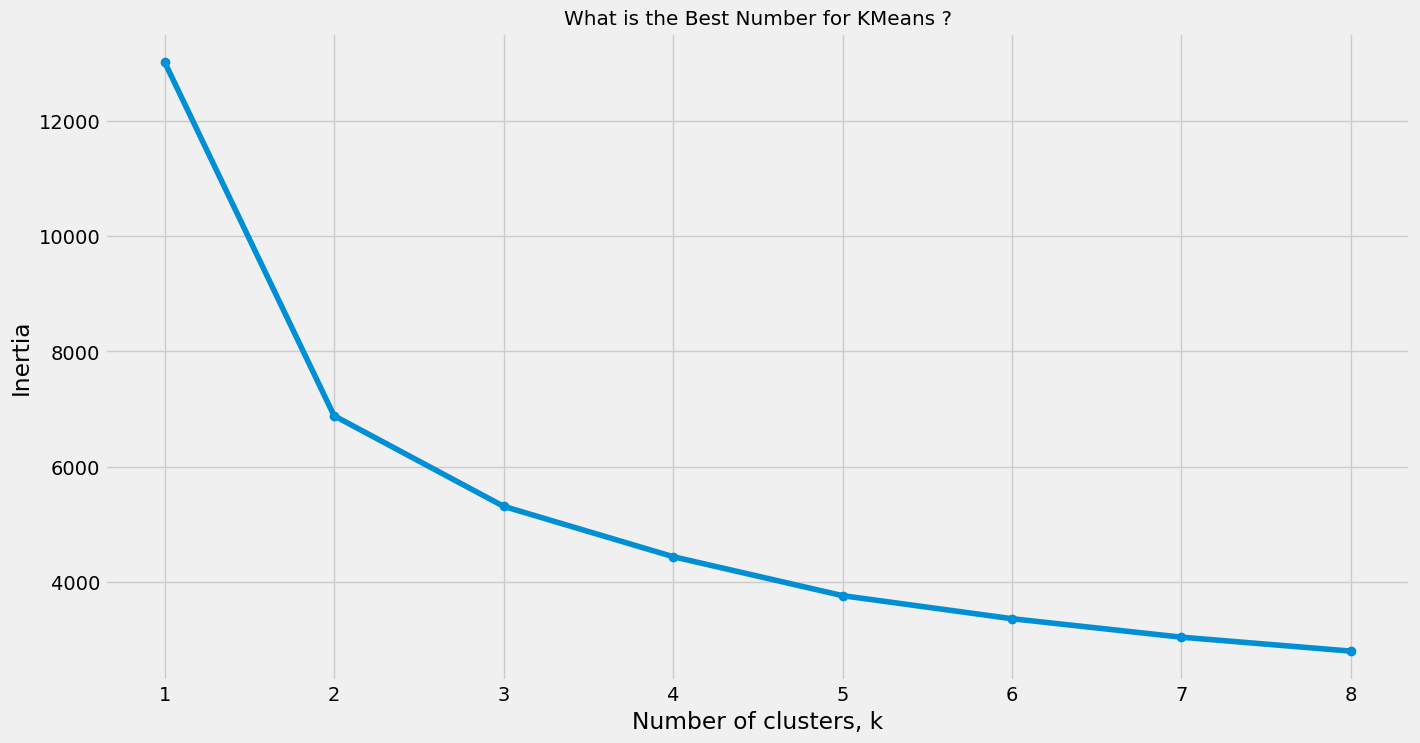

In [67]:
from sklearn.cluster import KMeans

#First : Get the best KMeans
ks = range(1, 9)
inertias = []
for k in ks:
    #Create a Kmean Cluster
    kc = KMeans(n_clusters=k, random_state=1)
    kc.fit(rfm_normalized)
    inertias.append(kc.inertia_)
    
#plot ks vs inertias
f, ax = plt.subplots(figsize=(15, 8))
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.style.use('ggplot')
plt.title('What is the Best Number for KMeans ?')
plt.show()

#### Note : We Choose NO.of KMeans = 3

In [68]:
#clustering
kc = KMeans(n_clusters=3, random_state=1)
kc.fit(rfm_normalized)

#Create a cluster label column in the original DataFrame
cluster_labels = kc.labels_

# Add the cluster labels to the DataFrame (this line fixes the error)
rfm['K_Cluster'] = cluster_labels

#Calculate average RFM values and size for each cluster:
rfm_rfm_k3 = rfm.groupby('K_Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count'],
}).round(0)

rfm_rfm_k3

Recency Frequency MonetaryValue      
             mean      mean          mean count
K_Cluster                                      
0            69.0      66.0        1183.0  1850
1            13.0     262.0        6610.0   945
2           170.0      15.0         294.0  1543

### Snake plots to understand and compare segments

In [69]:
rfm_normalized = pd.DataFrame(rfm_normalized, index=rfm_rfm.index, columns=rfm_rfm.columns)
rfm_normalized['K_Cluster'] = kc.labels_
rfm_normalized['General_Segment'] = rfm['General_Segment']
rfm_normalized.reset_index(inplace=True)

#Melt the data into a long format so RFM values and metric names are stored in 1 column each
rfm_melt = pd.melt(rfm_normalized, id_vars=['CustomerID', 'K_Cluster', 'General_Segment'], 
                  value_vars=['Recency', 'Frequency', 'MonetaryValue'], var_name='Metric', value_name='Value')
rfm_melt.head()

,CustomerID,K_Cluster,General_Segment,Metric,Value
0,12346.0,0,Silver,Recency,1.409982
1,12347.0,1,Gold,Recency,-2.146578
2,12348.0,0,Silver,Recency,0.383648
3,12349.0,0,Gold,Recency,-0.574961
4,12350.0,2,Bronze,Recency,1.375072


## Snake Plot and Heatmap

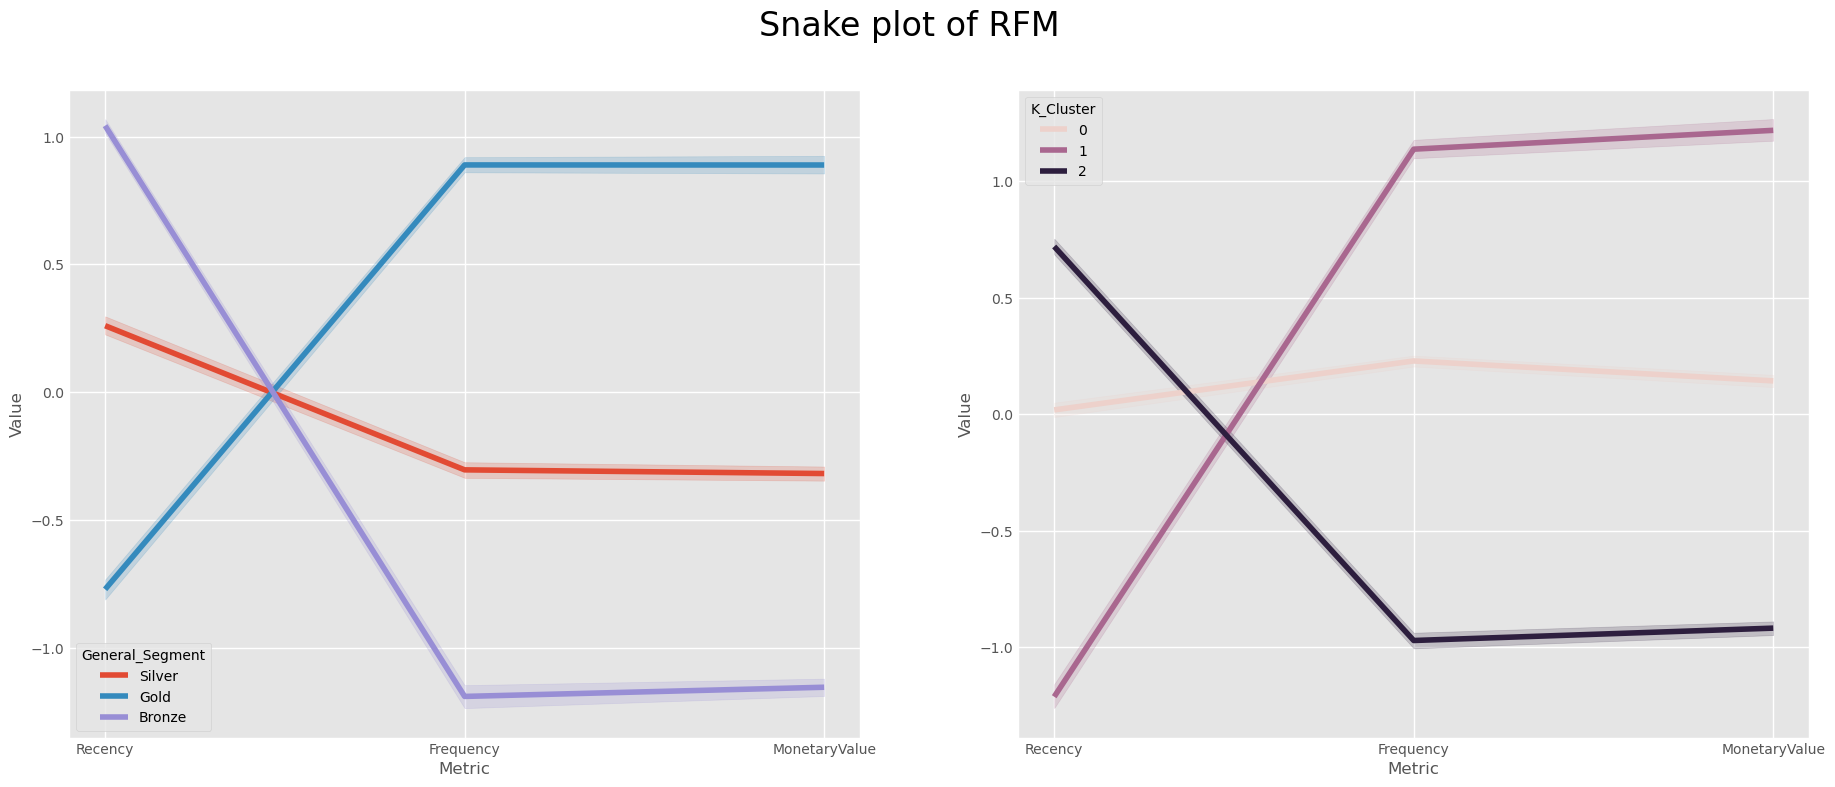

In [70]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
sns.lineplot(x='Metric', y='Value', hue='General_Segment', data=rfm_melt, ax=ax1)

#a snake plot with K-Means
sns.lineplot(x='Metric', y='Value', hue='K_Cluster', data=rfm_melt, ax=ax2)

plt.suptitle("Snake plot of RFM", fontsize=24)  #make title fontsize subtitle
plt.show()

#### Relative importance of segment attributes

In [71]:
# The Further a ratio is from 0, the more important that attribute is for a segment relative to the total population
cluster_avg = rfm_rfm_k3.groupby(['K_Cluster']).mean()

# Fix 1: make a copy of rfm_rfm_k3 with flat column names
#rfm_rfm_k3.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in rfm_rfm_k3.columns]

# Fix 2: compute population average using flattened columns
population_avg = rfm_rfm_k3.mean()

relative_imp = cluster_avg / population_avg - 1
relative_imp.round(2)

Recency Frequency MonetaryValue      
             mean      mean          mean count
K_Cluster                                      
0           -0.18     -0.42         -0.56  0.28
1           -0.85      1.29          1.45 -0.35
2            1.02     -0.87         -0.89  0.07

In [72]:
#the mean value in total

total_avg = rfm.iloc[:, 0:3].mean()
#Calculate the proportional gap with total mean
cluster_avg = rfm.groupby('General_Segment')[['Recency', 'Frequency', 'MonetaryValue']].mean().iloc[:, 0:3]
prop_rfm = cluster_avg / total_avg - 1
prop_rfm.round(2)

,Recency,Frequency,MonetaryValue
General_Segment,,,
Bronze,1.36,-0.88,-0.90
Gold,-0.71,1.09,1.15
Silver,0.08,-0.61,-0.65


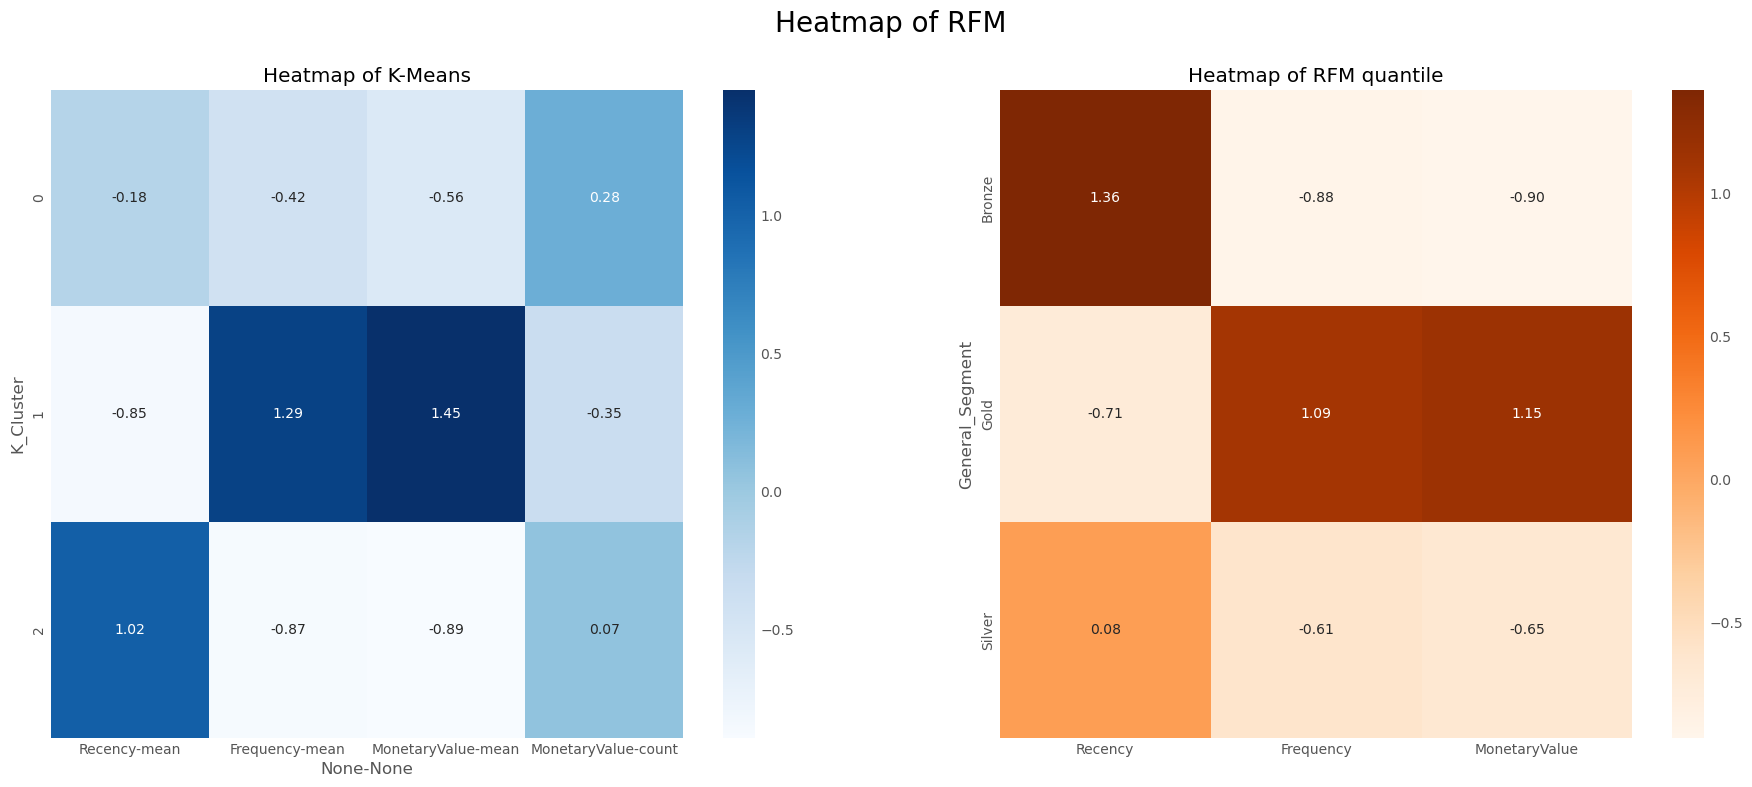

In [73]:
# heatmap with RFM
ff, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='Blues', ax=ax1)
ax1.set(title='Heatmap of K-Means')

# a snake plot with K-Means
sns.heatmap(prop_rfm, cmap='Oranges', fmt = '.2f', annot=True, ax=ax2)
ax2.set(title='Heatmap of RFM quantile')

plt.suptitle("Heatmap of RFM", fontsize=20)
plt.show()


In [74]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Remove rows without CustomerID
df = df.dropna(subset=['CustomerID'])

# Create TotalPrice = Quantity × UnitPrice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Set Analysis Date (1 day after last transaction date)
analysis_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# ------------------ RFM Calculation ------------------
# Recency
recency = df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
recency['Recency'] = (analysis_date - recency['InvoiceDate']).dt.days
recency = recency[['CustomerID', 'Recency']]

# Frequency
frequency = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
frequency.columns = ['CustomerID', 'Frequency']

# Monetary
monetary = df.groupby('CustomerID')['TotalPrice'].sum().reset_index()
monetary.columns = ['CustomerID', 'Monetary']

# Merge RFM
rfm = recency.merge(frequency, on='CustomerID').merge(monetary, on='CustomerID')

# ------------------ Tenure Calculation ------------------
first_purchase = df.groupby('CustomerID')['InvoiceDate'].min().reset_index()
first_purchase.columns = ['CustomerID', 'FirstPurchaseDate']
first_purchase['Tenure'] = (analysis_date - first_purchase['FirstPurchaseDate']).dt.days

# Add Tenure to RFM Table
rfm = rfm.merge(first_purchase[['CustomerID', 'Tenure']], on='CustomerID', how='left')

# Show RFM + Tenure
print(rfm)

      CustomerID  Recency  Frequency  Monetary  Tenure
0        12346.0      326          1  77183.60     326
1        12347.0        2          7   4310.00     367
2        12348.0       75          4   1797.24     358
3        12349.0       19          1   1757.55      19
4        12350.0      310          1    334.40     310
...          ...      ...        ...       ...     ...
4333     18280.0      278          1    180.60     278
4334     18281.0      181          1     80.82     181
4335     18282.0        8          2    178.05     126
4336     18283.0        4         16   2045.53     337
4337     18287.0       43          3   1837.28     202

[4338 rows x 5 columns]
